In [17]:
import numpy as np
from tqdm import tqdm
from urllib import request
import gzip
import pickle
import matplotlib.pyplot as plt

In [18]:
'''
Code for downloading MNIST handwritten digit dataset.
Ref: https://github.com/hsjeong5/MNIST-for-Numpy/blob/master/mnist.py
'''

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

init()

Download complete.
Save complete.


In [19]:
class rnn:
  def __init__(self, input_nodes, hidden_nodes, output_nodes):
    # since the dataset contains only 2 distinct values {0, 1}
    self.input_nodes = input_nodes
     # I like two
    self.hidden_nodes = hidden_nodes
    # I am not explaining this
    self.output_nodes = output_nodes
    # weights connecting input to hidden layer
    self.hi = np.random.randn(self.hidden_nodes, self.input_nodes)*0.1
    # weights connecting hidden to hidden layer, the recurrent connection
    self.hh = np.random.randn(self.hidden_nodes, self.hidden_nodes)*0.1
    # weights connecting hidden to output layer
    self.oh = np.random.randn(self.output_nodes, self.hidden_nodes)*0.1
    # hidden layer bias
    self.b1 = np.zeros((self.hidden_nodes, ))
    # output layer bias
    self.b2 = np.zeros((self.output_nodes, ))

  '''
  X: 2d numpy array of shape (no. of examples in dataset, input nodes)
  H_prev: prev timestep hidden state values
  h: 2d numpy array of shape (no. of examples in dataset, hidden nodes)
  o: 2d numpy array of shape (no. of examples in dataset, output nodes)
  '''
  def forward(self, X, H_prev):
    h = np.matmul(X, self.hi.T) + np.matmul(H_prev, self.hh.T) + self.b1
    h = np.tanh(h)
    o = np.matmul(h, self.oh.T) + self.b2
    o = 1 / (1 + np.exp(-o)) # sigmoid of o
    return h, o

  def error(self, Y, O):
    N = O.shape[1] # number of examples
    err = ((Y - O[-1])**2).sum()/ N
    return err

  def backward(self, T, X, Y, O, H):
    N = O.shape[1] # number of examples
    delta = np.zeros((N, self.hidden_nodes)) # (number of examples, hidden nodes)

    delta = -2*(Y - O[T-1])*O[T-1]*(1 - O[T-1]) # (number of examples, output nodes)
    self.doh += np.matmul(delta.T, H[T-1])/ N
    self.db2 += delta.T.sum(axis = 1)/ N
    delta = np.matmul(delta, self.oh) # (number of examples, hidden nodes)
    
    for t in range(T-1, -1, -1):
      delta *= (1 - H[t]**2)
      self.dhh += np.matmul(delta.T, H[t-1])/ N
      self.dhi += np.matmul(delta.T, X[t]) / N
      self.db1 += delta.T.sum(axis = 1)/ N

      delta = np.matmul(delta, self.hh) # (number of examples, hidden nodes)

  def clip_gradients(self):
    self.doh.clip(-1, 1, out = self.doh)
    self.dhh.clip(-1, 1, out = self.dhh)
    self.dhi.clip(-1, 1, out = self.dhi)
    self.db1.clip(-1, 1, out = self.db1)
    self.db2.clip(-1, 1, out = self.db2)

  def zero_gradients(self):
    self.doh = np.zeros((self.output_nodes, self.hidden_nodes))
    self.dhh = np.zeros((self.hidden_nodes, self.hidden_nodes))
    self.dhi = np.zeros((self.hidden_nodes, self.input_nodes))
    self.db1 = np.zeros((self.hidden_nodes, ))
    self.db2 = np.zeros((self.output_nodes, ))

  def update_parameters(self, alpha):
    self.oh -= (alpha*self.doh)
    self.hh -= (alpha*self.dhh)
    self.hi -= (alpha*self.dhi)
    self.b1 -= (alpha*self.db1)
    self.b2 -= (alpha*self.db2)

In [20]:
'''
Training the model
'''

T = 28 # time steps
x_train, y_train, x_test, y_test = load()
N = 60000 # no. of training examples
N_TEST = 10000 # no. of testing examples

INPUT_NODES = 28
OUTPUT_NODES = 10
HIDDEN_NODES = 256

BATCH_SIZE = 60
BATCHES = int(N/BATCH_SIZE)

if __name__ == "__main__":
    # dataset preparation
    X = x_train[:N].reshape(N, T, INPUT_NODES)/ 255
    Y = np.zeros((N, OUTPUT_NODES))
    for i in range(N):
        temp = np.zeros((OUTPUT_NODES, ))
        temp[y_train[i]] = 1
        Y[i] = temp
    
    model = rnn(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)
    
#---------------TRAINING THE MODEL---------------------------------------------------------------
    EPOCHS = 15
    ALPHA = 0.001
    training_loss = []
    
    for epoch in range(EPOCHS):
        # shuffle the examples
        perm = np.random.permutation(len(X))
        X = X[perm]
        Y = Y[perm]
        
        loss = 0.
        pbar = tqdm(range(BATCHES), unit = "batches")
        
        for batch in pbar:
            H = np.zeros((T+1, BATCH_SIZE, model.hidden_nodes))
            O = np.zeros((T, BATCH_SIZE, model.output_nodes))

            X_B = X[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE].transpose(1,0,2)
            Y_B = Y[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE]
            
            for t in range(T):
                H[t], O[t] = model.forward(X_B[t], H[t-1])

            # ensure gradients are initialised to zero
            model.zero_gradients()
        
            # compute gradients
            model.backward(T, X_B, Y_B, O, H)
        
            # clip the gradients before clipping
            model.clip_gradients()
        
            # update parameters
            model.update_parameters(ALPHA)

            curr_batch_loss = model.error(Y_B, O)
            pbar.set_description(f"Epoch: {epoch}, Batch: {batch}, loss: {round(curr_batch_loss, 2)}")
            
            loss += curr_batch_loss/ BATCHES

        print(f"Error after epoch {epoch}: {loss}")
        training_loss.append(loss)
    
    pickle.dump(training_loss, open("training_loss.pkl", "wb"))
    pickle.dump(model, open("model.pkl", "wb"))

  #----------------------------------------------------------------------------------------------

Epoch: 0, Batch: 999, loss: 0.6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.40batches/s]


Error after epoch 0: 0.785983389043887


Epoch: 1, Batch: 999, loss: 0.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.44batches/s]


Error after epoch 1: 0.49729095729888495


Epoch: 2, Batch: 999, loss: 0.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.67batches/s]


Error after epoch 2: 0.36229695064298906


Epoch: 3, Batch: 999, loss: 0.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92batches/s]


Error after epoch 3: 0.2837609988385493


Epoch: 4, Batch: 999, loss: 0.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.60batches/s]


Error after epoch 4: 0.2351199749693515


Epoch: 5, Batch: 999, loss: 0.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.15batches/s]


Error after epoch 5: 0.20335209859894418


Epoch: 6, Batch: 999, loss: 0.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.86batches/s]


Error after epoch 6: 0.18084091638305688


Epoch: 7, Batch: 999, loss: 0.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.84batches/s]


Error after epoch 7: 0.16419402979162745


Epoch: 8, Batch: 999, loss: 0.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  8.76batches/s]


Error after epoch 8: 0.15138173637084124


Epoch: 9, Batch: 999, loss: 0.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.83batches/s]


Error after epoch 9: 0.14103868793836424


Epoch: 10, Batch: 999, loss: 0.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.80batches/s]


Error after epoch 10: 0.13266005392821492


Epoch: 11, Batch: 999, loss: 0.1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.90batches/s]


Error after epoch 11: 0.12554477187117763


Epoch: 12, Batch: 999, loss: 0.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01batches/s]


Error after epoch 12: 0.11925362625124247


Epoch: 13, Batch: 999, loss: 0.12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.41batches/s]


Error after epoch 13: 0.11370946405124803


Epoch: 14, Batch: 999, loss: 0.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.53batches/s]

Error after epoch 14: 0.10912254921626438


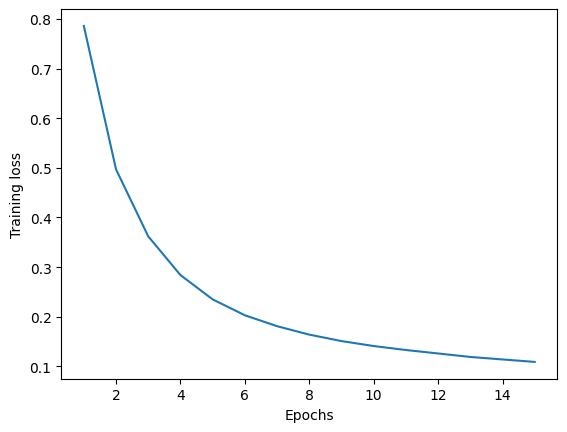

In [21]:
'''
plotting training loss vs epochs
'''
training_loss = pickle.load(open("training_loss.pkl", "rb"))
training_loss = [round(x, 3) for x in training_loss]
epochs = np.arange(0, EPOCHS) + 1
plt.plot(epochs, training_loss, label = "training loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.savefig('plot.png')
plt.show()

In [23]:
'''
Testing the model
'''

model = pickle.load(open("model.pkl", "rb"))
# dataset preparation
X_TEST = x_test[:N_TEST].reshape(N_TEST, T, INPUT_NODES)/ 255
X_TEST = X_TEST.transpose(1, 0, 2)
Y_TEST = y_test[:N_TEST].T

H_TEST = np.zeros((T+1, N_TEST, model.hidden_nodes))
O_TEST = np.zeros((T, N_TEST, model.output_nodes))

for t in tqdm(range(T), desc = f"Running forward pass.."):
    H_TEST[t], O_TEST[t] = model.forward(X_TEST[t], H_TEST[t-1])

correct_ans = (np.argmax(O_TEST[-1], axis = 1) == Y_TEST).sum()
accuracy = (correct_ans/ N_TEST) * 100
print(f"Test Accuracy: {accuracy}")

Running forward pass..: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.26it/s]

Test Accuracy: 93.7
